In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils.models import RGCN_v1, gwnet_wrapper
from utils.xai_utils import integrated_gradients

plt.style.use('dark_background')
np.random.seed(123)
torch.manual_seed(123)

# Set up general arguments and pull in some real River-dl data

In [ ]:
## Define some general arguments for the notebook
mod = 'GWN'  #GWN or RGCN
base = 'mean' #zeros or mean
grad_steps = 5 #Number of steps to take in calculation of IG
year_index = -1 #Sequence to apply IG to
weights_file = '../../river-dl/results/baseline/GWN/rep_5/finetuned_weights.pth'
prepped_file = "../../river-dl/results/baseline/GWN/prepped.npz"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pred_length = 15

river_dl = np.load(prepped_file)
num_vars = len(river_dl['x_vars'])
seq_len = river_dl['x_trn'].shape[1]
adj_matrix = river_dl['dist_matrix']
n_segs = adj_matrix.shape[0]

if base == 'zeros':
    x = torch.from_numpy(river_dl['x_trn']).float()[455*year_index:]
    baseline = torch.zeros_like(x)

elif base == 'mean':
    x = torch.from_numpy(river_dl['x_trn']).float()
    n_series = river_dl['x_trn'].shape[0]
    baseline = x.reshape(n_series//n_segs,n_segs,seq_len,num_vars)
    baseline = torch.mean(baseline,dim=0)
    x = x[455*year_index:]

dates_x = river_dl['times_trn'][455*year_index:][0].flatten()


x.shape,baseline.shape, adj_matrix.shape

In [3]:
if mod == 'RGCN':
    model = RGCN_v1(num_vars, 20, adj_matrix)
    model.load_state_dict(torch.load(weights_file, map_location=device))

elif mod == 'GWN':
    supports = [torch.tensor(adj_matrix).to(device).float()]
    out_dim = pred_length
    model = gwnet_wrapper(device,n_segs,supports=supports,aptinit=supports[0],
    in_dim=num_vars,out_dim=out_dim,layers=3, kernel_size=5,blocks=3, weights_path=weights_file,
                          nsegs=n_segs)

<All keys matched successfully>

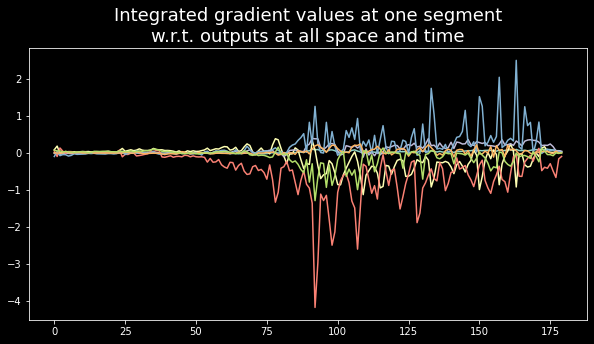

In [9]:
IG_vals = integrated_gradients(x, model, 2, torch.zeros_like(x), temporal_focus=range(90,180))

plt.figure(figsize = (10, 5))
for i in range(7):
    plt.plot(IG_vals[0, :, i])
plt.title('Integrated gradient values at one segment\nw.r.t. outputs at all space and time',
          fontsize = 18);

In [9]:
time_sum = np.sum(IG_vals,axis=0)
space_sum = np.sum(IG_vals,axis=1)
space_sum.shape, time_sum.shape

((455, 7), (180, 7))

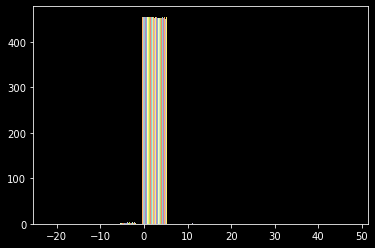

In [15]:
plt.hist(IG_vals[:,:,0])
plt.show()

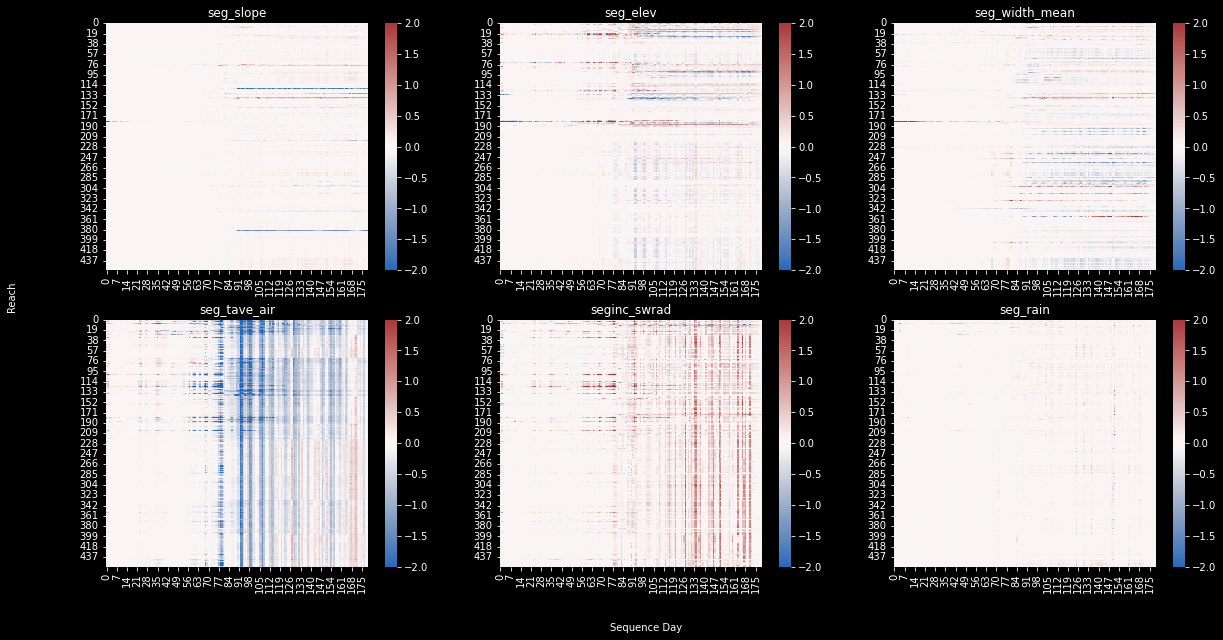

In [18]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10))
#cmap = sns.palplot(sns.diverging_palette(240, 10, n=9))
for i in range(6):
    sns.heatmap(IG_vals[:,:,i], vmin=-2,vmax=2, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i])
fig.text(0.5, 0.04, 'Sequence Day', ha='center', va='center')
fig.text(0.06, 0.5, 'Reach', ha='center', va='center', rotation='vertical')
plt.tight_layout
plt.show()

## lets try to make a seg to seg heatmap

In [19]:
seg2seg_influence = []
for i in range(455):
    IG_vals = integrated_gradients(x, model, 2, torch.zeros_like(x), temporal_focus=range(90,180), spatial_focus=i)
    reduced = np.mean(IG_vals,axis=1)
    seg2seg_influence.append(reduced)

In [20]:
check = np.asarray(seg2seg_influence)

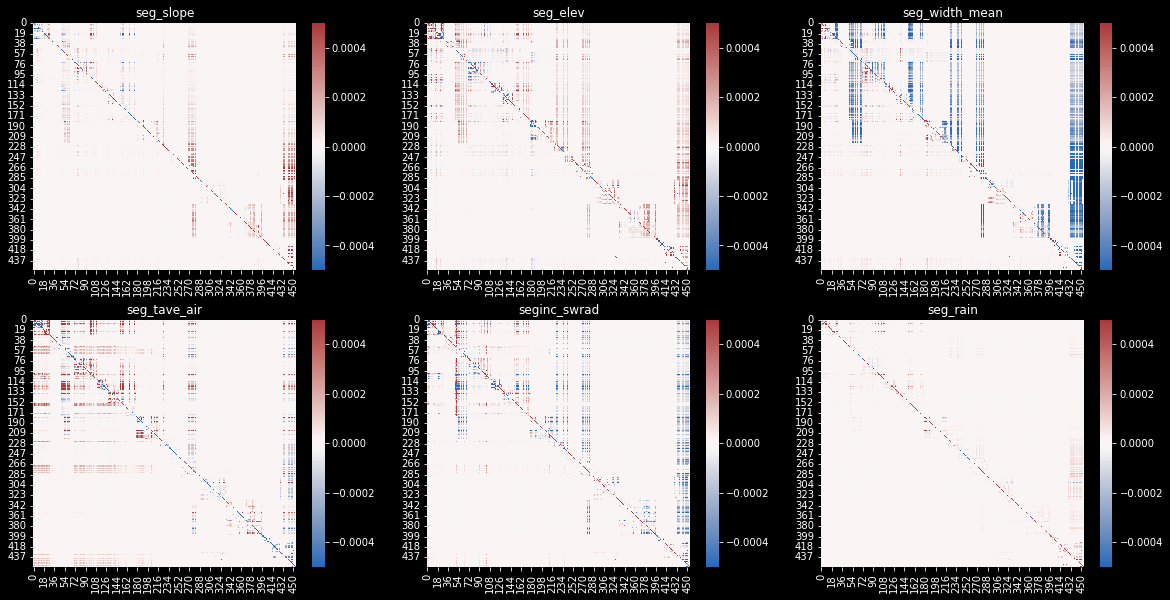

In [24]:
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(20,10))

for i in range(6):
    sns.heatmap(check[:,:,i], vmin=-.0005,vmax=.0005, cmap='vlag', ax=axes.reshape(-1)[i])
    axes.reshape(-1)[i].set_title(river_dl['x_vars'][i])

plt.tight_layout
plt.show()

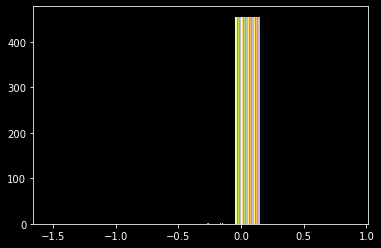

In [78]:
plt.hist(check[:,:,0])
plt.show()